# Setup

In [1]:
DATA_VERSION = "2025-11-17"
DATA_FILE_NAME = f"consultation-documents-preprocessed-{DATA_VERSION}.parquet"
EXTRA_DOCUMENT_FEATURES_FILE_NAME = f"consultation-documents-features-{DATA_VERSION}.parquet"
EMBEDDINGS_FILE_NAME = (
    f"consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-{DATA_VERSION}.parquet"
)

LANGUAGES = {
    "de",
    # "fr",
    # "it",
}

FROM_YEAR = 2000

# Do not train nor test on documents from cantons that have known data quality issues.
EXCLUDE_POLITICAL_BODIES = {
    "bl",
    "ge",
    "ne",
    "sz",
    "vd",
    "vs",
}

INCLUDE_RULE_LABELS_IN_TRAINING = {
    # These are labels after class merging.
    "SYNOPTIC_TABLE",
    "LETTER",
    "RECIPIENT_LIST",
    "FINAL_REPORT",
    "SURVEY",
}

CV_FOLDS = 5
# This fraction only applies to manually labelled OpenParlData documents. Many more documents make it
# into the training set, e.g. all Fedlex documents.
TEST_SIZE = 0.15
RANDOM_STATE = 271828

# RUN_HYPEROPTIMIZATION = True
# HYPERPARAMETERS = None

RUN_HYPEROPTIMIZATION = False
# HYPERPARAMETERS = {
#     "classifier": {
#         "type": "MLP",
#         "activation": "relu",
#         "alpha": 7.347549520407708e-05,
#         "batch_size": 144,
#         "layer_1": 240,
#         "layer_2": 48,
#         "layer_3": 208,
#         "learning_rate_init": 0.00013505066692205835,
#         "n_layers": 1,
#         "solver": "adam",
#     },
#     "pca_n_components": 360,
# }
HYPERPARAMETERS = {
    # "classifier": {
    #     "type": "SVC",
    #     "C": 1.0,
    #     "class_weight": None,
    #     "gamma": "scale",
    #     "kernel": {"type": "rbf"},
    # },
    # "classifier": {
    #     "type": "RandomForest",
    #     "n_estimators": 100,
    #     "criterion": "gini",
    #     "max_depth": None,
    #     "min_samples_split": 2,
    #     "min_samples_leaf": 1,
    #     "class_weight": None,
    # },
    "classifier": {
        "type": "XGBoost",
    },
    "pca_n_components": 100,
}

assert RUN_HYPEROPTIMIZATION ^ bool(HYPERPARAMETERS)

In [2]:
%load_ext autoreload
%autoreload 2

import datetime
import logging
import pathlib
import sys
from typing import Any

import dotenv
import duckdb
import hyperopt
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline
from hyperopt import pyll

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
import demokratis_ml.data.loading
import demokratis_ml.models.document_types.model
import demokratis_ml.models.document_types.preprocessing
from research.document_types import document_title_rule_model, training_split
from research.lib import data_access, plotting, utils

In [4]:
dotenv.load_dotenv()
utils.set_up_logging_and_mlflow("VM_document_type_classifier")

mlflow.log_param("data_version", DATA_VERSION)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("extra_features_file", EXTRA_DOCUMENT_FEATURES_FILE_NAME)
mlflow.log_param("embeddings_file", EMBEDDINGS_FILE_NAME)
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
mlflow.log_param("run_hyperoptimization", RUN_HYPEROPTIMIZATION)
mlflow.log_param("include_rule_labels_in_training", sorted(INCLUDE_RULE_LABELS_IN_TRAINING))
mlflow.log_param("exclude_political_bodies", sorted(EXCLUDE_POLITICAL_BODIES))
mlflow.log_param("merge_classes", demokratis_ml.models.document_types.preprocessing.MERGE_CLASSES)
;

INFO research.lib.utils: MLflow tracking to https://mlflow.ml1.demokratis.ch/
INFO research.lib.utils: Starting run = tasteful-fowl-449


''

# Input data preparation

## Get all dataframes

In [5]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)

FEATURES_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EXTRA_DOCUMENT_FEATURES_FILE_NAME
data_access.ensure_dataframe_is_available(FEATURES_DATA_FILE)

EMBEDDINGS_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EMBEDDINGS_FILE_NAME
data_access.ensure_dataframe_is_available(EMBEDDINGS_DATA_FILE)

INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-11-17.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-features-2025-11-17.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-2025-11-17.parquet already exists locally.


In [6]:
db_conn = duckdb.connect(":memory:")

rel_docs = demokratis_ml.data.loading.filter_documents(
    db_conn.from_parquet(str(PREPROCESSED_DATA_FILE)),
    only_languages=LANGUAGES,
    only_consultations_since=datetime.date(FROM_YEAR, 1, 1),
)
rel_features = db_conn.from_parquet(str(FEATURES_DATA_FILE))
rel_embeddings = db_conn.from_parquet(str(EMBEDDINGS_DATA_FILE))

## Preprocess

In [7]:
df_input = demokratis_ml.models.document_types.preprocessing.create_input_dataframe(
    rel_docs, rel_extra_features=rel_features, rel_embeddings=rel_embeddings
)
df_input

INFO document_types.preprocessing: Dropping 0 documents (0.0%) with empty texts


,document_uuid,consultation_identifier,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,consultation_internal_tags,...,average_page_aspect_ratio,embedding,fraction_pages_containing_tables,fraction_pages_containing_images,contains_synopse_keyword,contains_salutation,days_after_consultation_start,days_after_consultation_end,consultation_start_timestamp,is_federal_consultation
0,1CAJoURQMxKeqCdQ4jLniS,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,0.704898,"[0.01030252780765295, -0.014312159270048141, -...",0.000000,0.000000,False,False,4.0,-104.0,1633046400,True
1,1CAJoURQMxKeqCdQ4vhCQx,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,0.707098,"[0.011395552195608616, 0.0014780974015593529, ...",0.000000,0.166667,False,False,4.0,-104.0,1633046400,True
2,1CAJoURQMxKeqCdQ564eYH,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,0.707098,"[-0.005767590366303921, 0.002646328415721655, ...",0.000000,0.500000,False,True,4.0,-104.0,1633046400,True
3,1CAJoURQbi5gxw7Wp5N5rT,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,0.707098,"[0.019797369837760925, -0.00907826703041792, -...",0.000000,0.400000,False,False,4.0,-104.0,1633046400,True
4,1CAJoURQbi5gxw7WpL8ns1,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,0.707098,"[-0.001758241094648838, 0.002000046195462346, ...",0.000000,0.500000,False,True,4.0,-104.0,1633046400,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21543,1CV8n3KN3uURuWcVgXEWDT,h3xxzqu6,2025-11-12,2026-02-10,Totalrevision Polizeigesetz,Das geltende Polizeigesetz ist 2011 in Kraft g...,https://www.ow.ch/_doc/433615,https://www.demokratis.ch/vernehmlassung/h3xxzqu6,"[it, security]","[{'created_at': 2025-11-16 14:47:37, 'name': '...",...,0.706912,"[0.04022208973765373, -0.048298429697752, -0.0...",0.000000,0.000000,False,False,-8.0,-98.0,1762905600,False
21544,1CV8n3KN3uURuWcVgbXP22,h3xxzqu6,2025-11-12,2026-02-10,Totalrevision Polizeigesetz,Das geltende Polizeigesetz ist 2011 in Kraft g...,https://www.ow.ch/_doc/433618,https://www.demokratis.ch/vernehmlassung/h3xxzqu6,"[it, security]","[{'created_at': 2025-11-16 14:47:37, 'name': '...",...,1.414603,"[0.04114928096532822, -0.03175993636250496, -0...",1.000000,0.000000,False,False,0.0,-90.0,1762905600,False
21545,1CV8n3MDuuhQupKbR5UAPX,p58rm7t9,2025-11-13,2026-01-12,Anpassung kantonaler Richtplan 25/2: Siedlungs...,Der Kanton Zug passt den kantonalen Richtplan ...,https://zg.ch/dam/jcr:06a631bd-f3dd-4f54-9729-...,https://www.demokratis.ch/vernehmlassung/p58rm7t9,"[agriculture, environmen

In [8]:
embedding_dimension = df_input["embedding"].iloc[0].shape[0]
print("Embedding dimension:", embedding_dimension)

Embedding dimension: 3072


In [9]:
print(
    "Excluding documents from these political bodies from the data:",
    df_input[df_input["political_body"].isin(EXCLUDE_POLITICAL_BODIES)]["political_body"].astype(str).value_counts(),
    sep="\n",
)
df_input = df_input[~df_input["political_body"].isin(EXCLUDE_POLITICAL_BODIES)]

Excluding documents from these political bodies from the data:
political_body
sz    440
vs     12
bl      9
Name: count, dtype: int64


## Split

In [10]:
test_sizes = (TEST_SIZE, TEST_SIZE) if RUN_HYPEROPTIMIZATION else (TEST_SIZE,)
df_input_train, _test_dfs = training_split.train_test_split(
    df_input,
    random_state=RANDOM_STATE,
    test_sizes=test_sizes,
    include_rule_labels_in_training=INCLUDE_RULE_LABELS_IN_TRAINING,
    stratify_by_canton=False,
)
if RUN_HYPEROPTIMIZATION:
    df_input_test_1, df_input_test_2 = _test_dfs
else:
    df_input_test_2 = _test_dfs[0]
    df_input_test_1 = pd.DataFrame(columns=df_input_test_2.columns)

INFO document_title_rule_model: 0.00% of documents already have labels
INFO document_title_rule_model: Labelled 0.03% by rule: canton=<any>, title^=adressliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 3.95% by rule: canton=<any>, title^=adressatenliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.35% by rule: canton=<any>, title^=adressatenverzeichnis => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 1.11% by rule: canton=<any>, title^=vernehmlassungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=vernehmlassungsadressen => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=verzeichnis der anhörungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=liste der konsultationsadressatinnen und konsultationsadressaten => type=RECIPIENT_LIST
WARNING document_ti

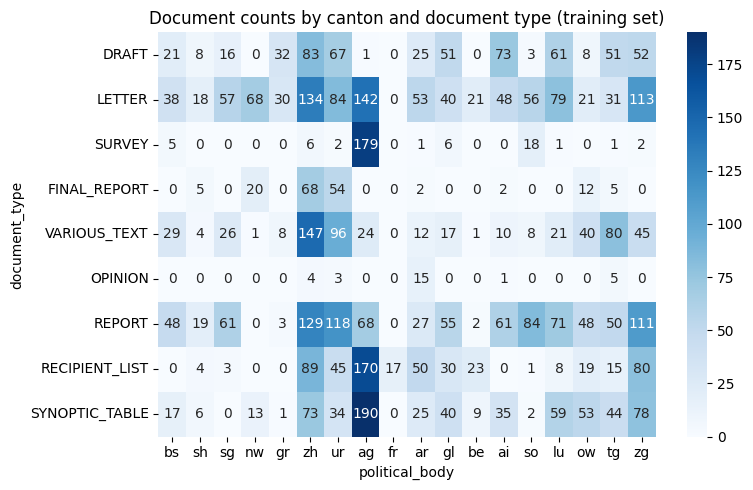

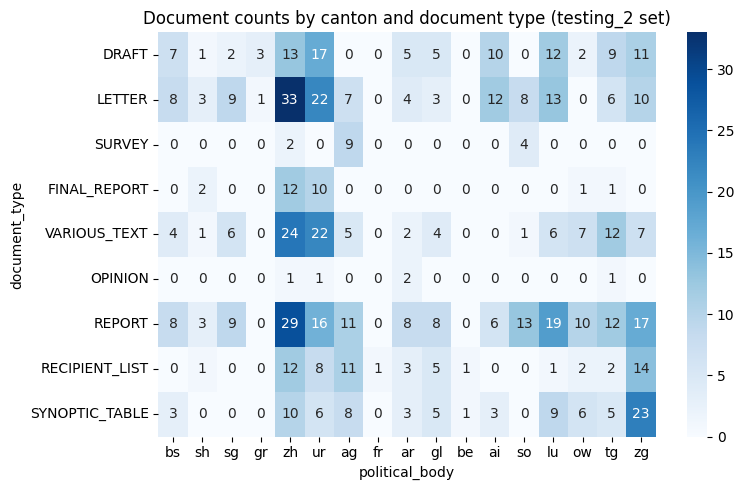

In [11]:
def plot_documents_per_canton(df: pd.DataFrame, set_name: str) -> None:
    df = df[df["political_body"] != "ch"]
    count_matrix = pd.crosstab(df["document_type"], df["political_body"])
    count_matrix = count_matrix.fillna(0)
    plt.figure(figsize=(8, 5))
    sns.heatmap(count_matrix, annot=True, fmt="g", cmap="Blues")
    plt.title(f"Document counts by canton and document type ({set_name} set)")
    plt.tight_layout()
    plt.show()


plot_documents_per_canton(df_input_train, "training")
plot_documents_per_canton(df_input_test_2, "testing_2")

In [12]:
display(df_input_train["document_type_label_source"].value_counts(dropna=False))
display(df_input_train["document_type"].value_counts(dropna=False))

document_type_label_source
fedlex    13222
manual     3932
rule        827
Name: count, dtype: int64

document_type
LETTER            3667
DRAFT             3584
REPORT            3205
RECIPIENT_LIST    2403
FINAL_REPORT      1993
OPINION           1055
VARIOUS_TEXT       995
SYNOPTIC_TABLE     827
SURVEY             252
RESPONSE_FORM        0
DECISION             0
LINK                 0
PRESS_RELEASE        0
Name: count, dtype: int64

In [13]:
display(df_input_test_2["document_type_label_source"].value_counts(dropna=False))
display(df_input_test_2["document_type"].value_counts(dropna=False))

document_type_label_source
manual    695
rule        0
fedlex      0
Name: count, dtype: int64

document_type
REPORT            169
LETTER            139
VARIOUS_TEXT      101
DRAFT              97
SYNOPTIC_TABLE     82
RECIPIENT_LIST     61
FINAL_REPORT       26
SURVEY             15
OPINION             5
RESPONSE_FORM       0
DECISION            0
LINK                0
PRESS_RELEASE       0
Name: count, dtype: int64

In [14]:
mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_1_samples_count", len(df_input_test_1))
mlflow.log_param("test_2_samples_count", len(df_input_test_2))

695

# Data exploration

## Data representation

In [15]:
print("df_input_train labels:")
df_input_train.groupby("document_type_label_source", observed=False)["document_type"].value_counts(dropna=False)

df_input_train labels:


document_type_label_source  document_type 
rule                        LETTER             246
                            SYNOPTIC_TABLE     217
                            RECIPIENT_LIST     210
                            SURVEY             133
                            FINAL_REPORT        21
                            DRAFT                0
                            RESPONSE_FORM        0
                            DECISION             0
                            LINK                 0
                            VARIOUS_TEXT         0
                            OPINION              0
                            REPORT               0
                            PRESS_RELEASE        0
manual                      REPORT             955
                            LETTER             787
                            VARIOUS_TEXT       569
                            DRAFT              552
                            SYNOPTIC_TABLE     462
                            RECIPIENT_L

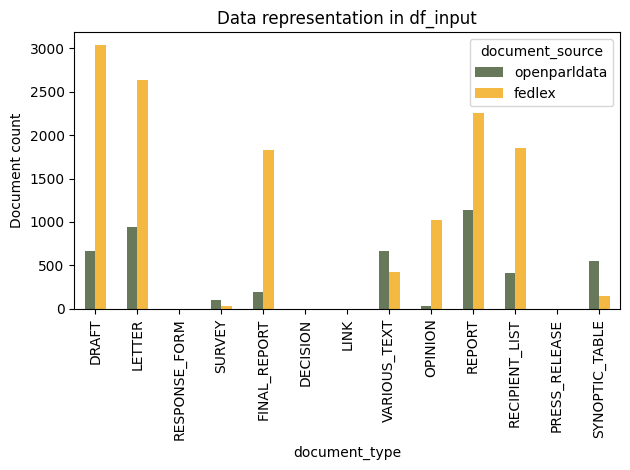

document_source,openparldata,fedlex
document_type,,
DRAFT,661,3032
LETTER,941,2634
RESPONSE_FORM,0,0
SURVEY,105,31
FINAL_REPORT,189,1825
DECISION,0,0
LINK,0,0
VARIOUS_TEXT,670,426
OPINION,34,1027


In [16]:
repr_table = df_input.pivot_table(
    index="document_type", columns="document_source", aggfunc="size", fill_value=0, observed=False
)
display(
    plotting.plot_and_log(
        repr_table.plot,
        "data_representation.png",
        title="Data representation in df_input",
        kind="bar",
        ylabel="Document count",
        color=["#68785A", "#F4B942"],
    )
)
display(repr_table)

## Extra features

In [17]:
print("contains_salutation:")
df_input.pivot_table(
    index="document_type",
    columns="document_source",
    values="contains_salutation",
    aggfunc="mean",
    fill_value=0,
    observed=False,
)

contains_salutation:


document_source,openparldata,fedlex
document_type,,
DRAFT,0.000000,0.000989
LETTER,0.994687,0.985194
SURVEY,0.028571,0.000000
FINAL_REPORT,0.058201,0.002740
VARIOUS_TEXT,0.043284,0.014085
OPINION,0.647059,0.735151
REPORT,0.114336,0.012444
RECIPIENT_LIST,0.000000,0.000000
SYNOPTIC_TABLE,0.001815,0.000000


### Keyword-like features

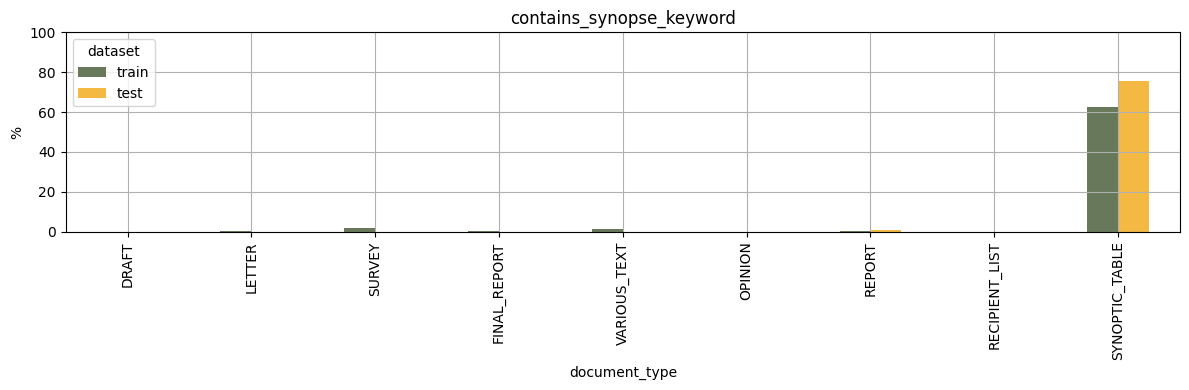

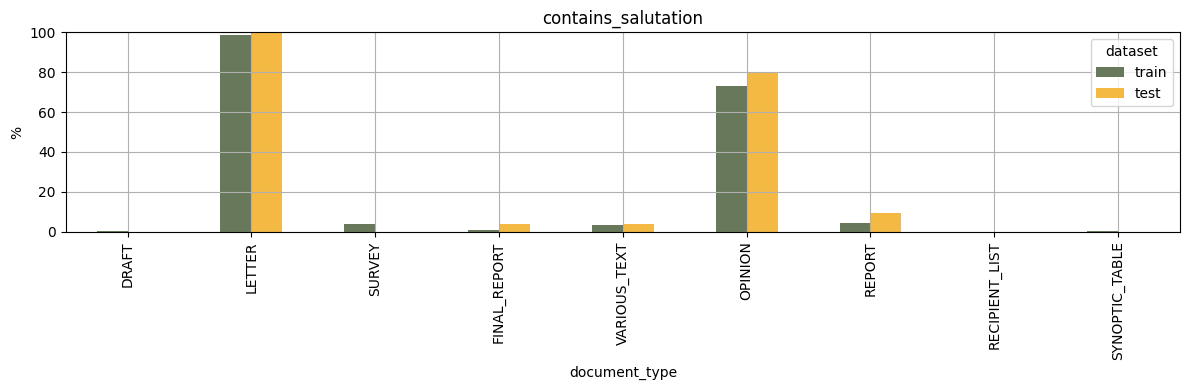

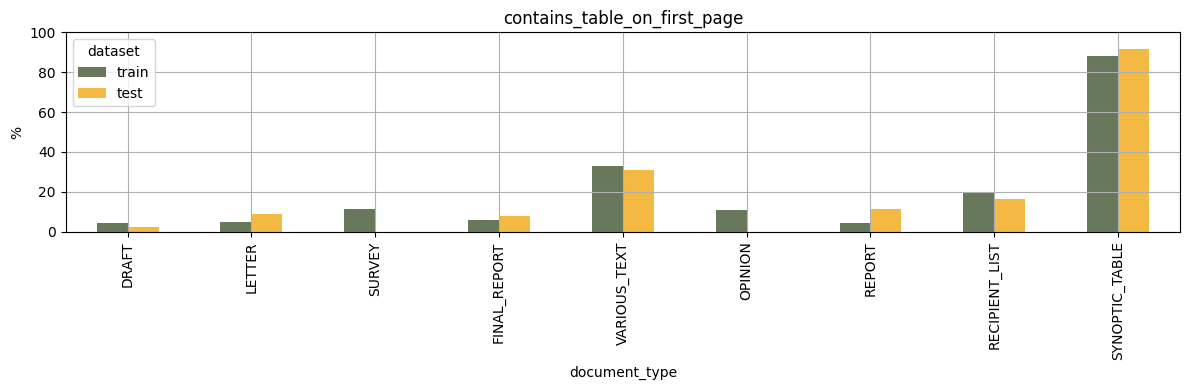

In [18]:
def plot_binary_feature_across_document_types(df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str) -> None:
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    pivot_table = df.pivot_table(
        index="document_type",
        columns="dataset",
        values=feature_name,
        aggfunc=lambda x: 100 * x.mean(),
        fill_value=0,
        observed=False,
    )
    pivot_table = pivot_table[["train", "test"]]  # Ensure "train" comes first
    ax = pivot_table.plot(
        kind="bar",
        # figsize=(20, 10),
        figsize=(12, 4),
        title=feature_name,
        ylabel="%",
        ylim=(0, 100),
        color=["#68785A", "#F4B942"],
        grid=True,
    )
    ax.figure.patch.set_alpha(0.0)
    ax.patch.set_alpha(0.0)
    plt.tight_layout()
    plt.show()


plot_binary_feature_across_document_types(df_input_train, df_input_test_2, "contains_synopse_keyword")
plot_binary_feature_across_document_types(df_input_train, df_input_test_2, "contains_salutation")
plot_binary_feature_across_document_types(df_input_train, df_input_test_2, "contains_table_on_first_page")

In [19]:
def plot_feature_distribution_across_document_types(
    df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str, clip_y: None | tuple[int, int] = None
) -> None:
    plt.figure(figsize=(14, 5))
    # plt.figure(figsize=(20, 10))
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
        ignore_index=True,
    )
    ax = sns.violinplot(
        data=df,
        x="document_type",
        y=feature_name,
        hue="dataset",
        order=sorted(df["document_type"].unique()),
        # inner="box",  # Show boxplot inside violin
        inner=None,  # Show only violin
        split=True,
        linewidth=0.1,
        palette={"train": "#68785A", "test": "#F4B942"},
    )
    # ax.set_ylim(bottom=0, top=1)
    ax.figure.patch.set_alpha(0.0)
    ax.patch.set_alpha(0.0)
    plt.xticks(rotation=90)
    if clip_y:
        sample = df[feature_name].dropna()
        ax.set_ylim(*np.percentile(sample, clip_y))
        plt.title(f"{feature_name} (clipped to {clip_y[0]}-{clip_y[1]}th percentile)")
    else:
        plt.title(feature_name)
    plt.tight_layout()
    plt.show()

### Page count, aspect ratio

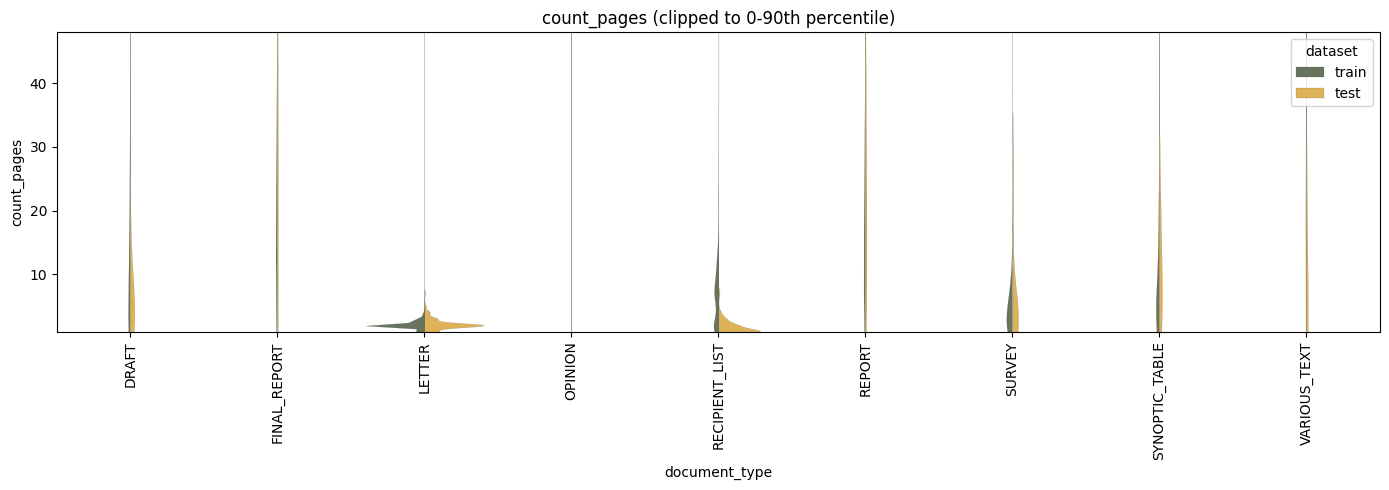

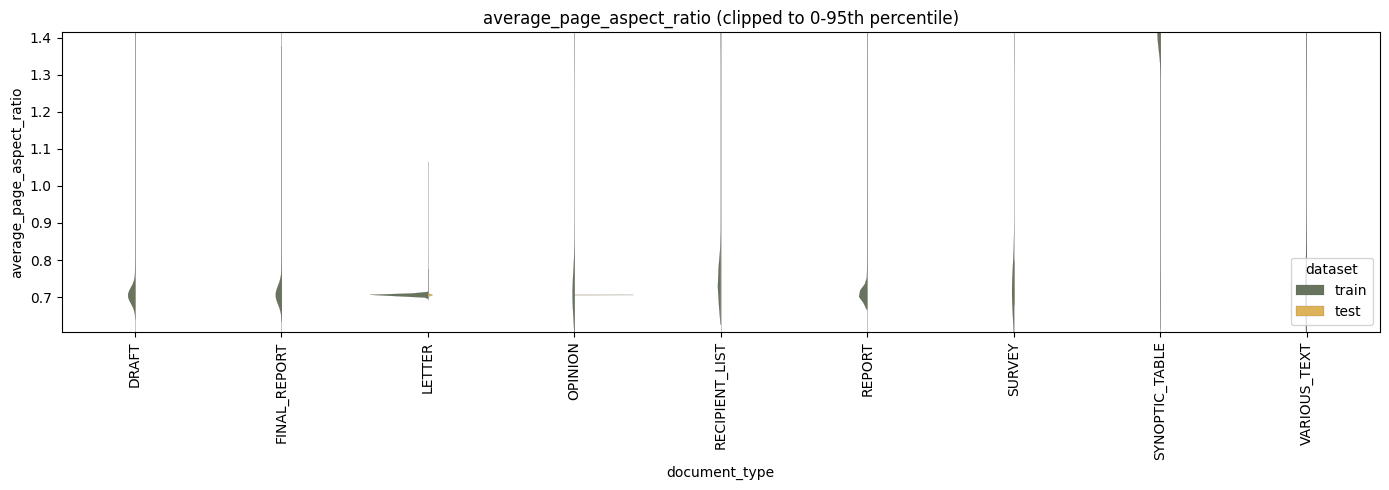

In [20]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "count_pages", clip_y=(0, 90))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test_2, "average_page_aspect_ratio", clip_y=(0, 95)
)

In [21]:
print("count_pages")
pd.concat([df_input_train.assign(dataset="train"), df_input_test_2.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="count_pages",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

count_pages


mean                    std            
dataset               test       train       test       train
document_type                                                
DRAFT             8.742268   13.150112  13.577922   42.721940
LETTER            2.179856    2.151350   0.894847    1.330227
SURVEY            5.533333    4.817460   7.239442    7.473620
FINAL_REPORT     32.192308   26.888610  47.332880   42.446927
VARIOUS_TEXT     18.871287   18.123618  30.168084  126.245098
OPINION         118.000000  402.308057  86.055215  854.536471
REPORT           30.195266   25.414665  32.911910   33.900990
RECIPIENT_LIST    1.639344    7.142322   1.065094    5.585358
SYNOPTIC_TABLE   12.829268   10.845224  15.545874   15.281784

In [22]:
print("average_page_aspect_ratio")
pd.concat([df_input_train.assign(dataset="train"), df_input_test_2.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="average_page_aspect_ratio",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

average_page_aspect_ratio


mean                 std          
dataset             test     train      test     train
document_type                                         
DRAFT           0.717183  0.727504  0.076926  0.108024
LETTER          0.707542  0.707744  0.005633  0.013594
SURVEY          0.715728  0.776936  0.023142  0.192478
FINAL_REPORT    0.765468  0.730685  0.146663  0.113045
VARIOUS_TEXT    0.828169  0.884997  0.268188  0.358448
OPINION         0.707192  0.786744  0.000133  0.199587
REPORT          0.758502  0.725005  0.151389  0.085733
RECIPIENT_LIST  0.824121  0.770984  0.263756  0.179383
SYNOPTIC_TABLE  1.379886  1.363236  0.140317  0.175863

### Tables

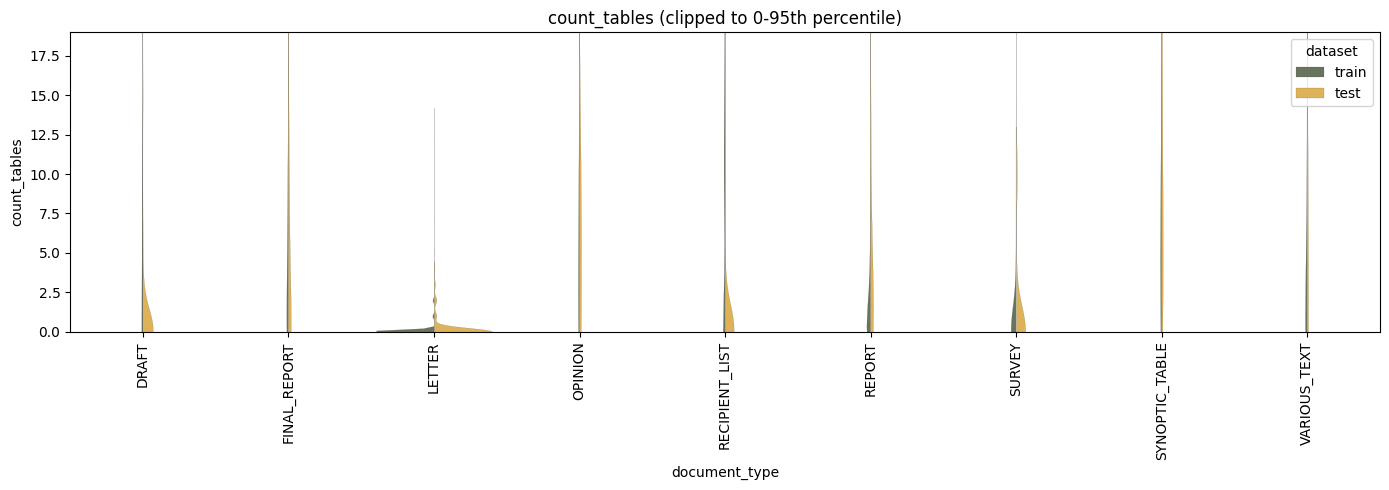

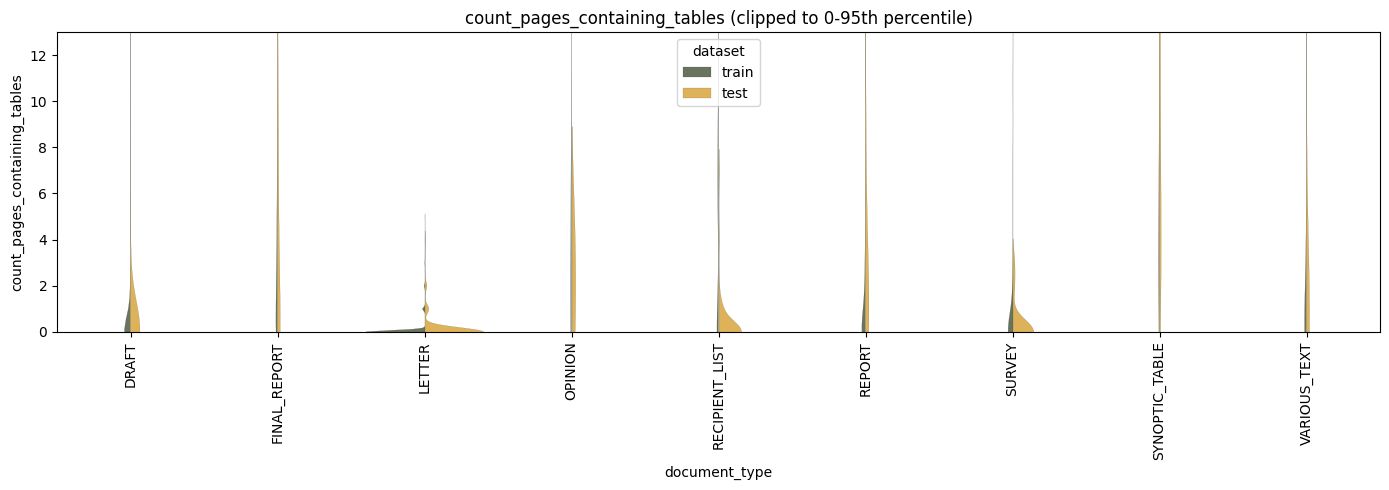

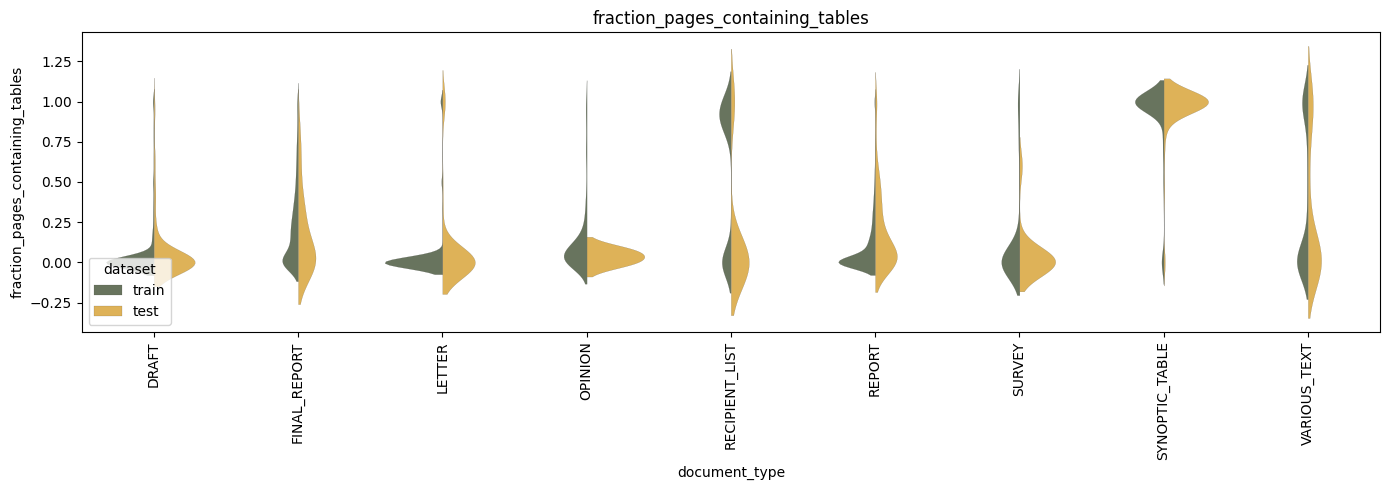

In [23]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "count_tables", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test_2, "count_pages_containing_tables", clip_y=(0, 95)
)
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "fraction_pages_containing_tables")

### Images

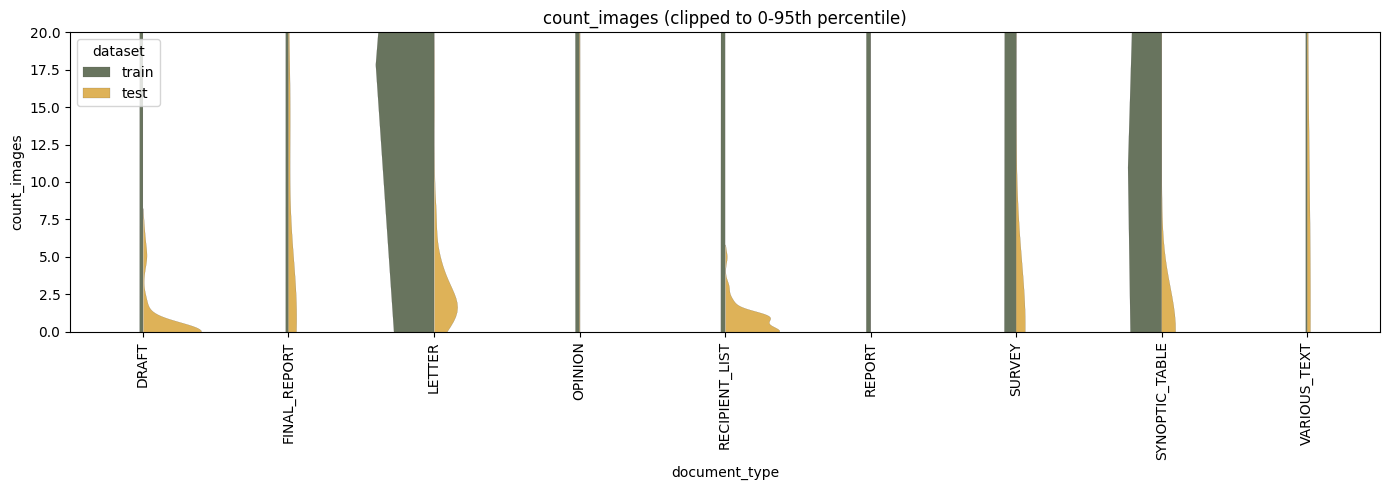

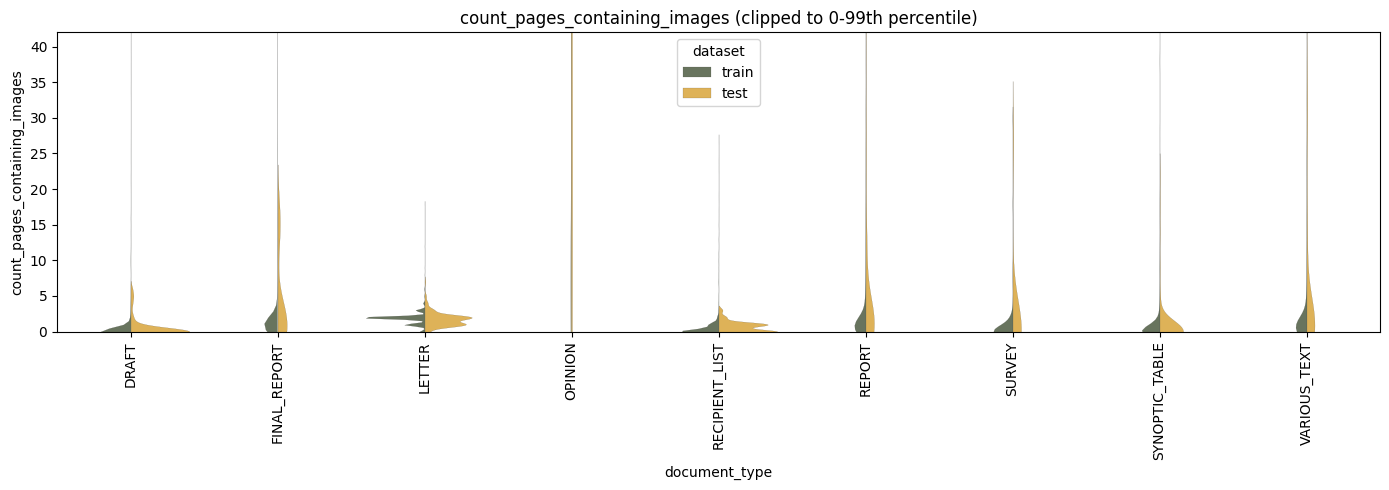

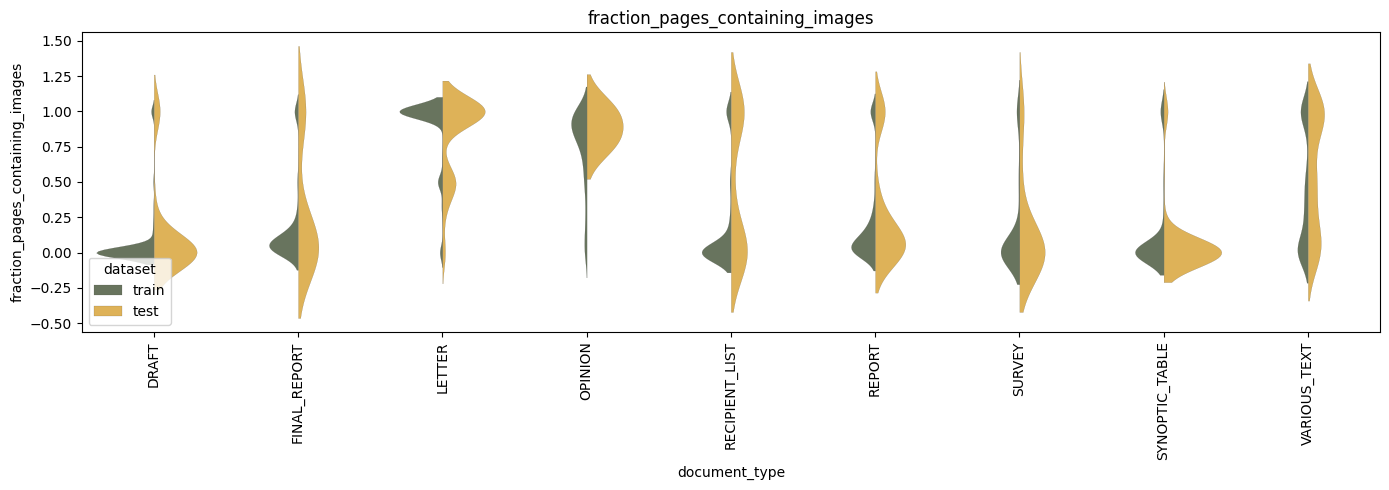

In [24]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "count_images", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test_2, "count_pages_containing_images", clip_y=(0, 99)
)
plot_feature_distribution_across_document_types(df_input_train, df_input_test_2, "fraction_pages_containing_images")

### Time features

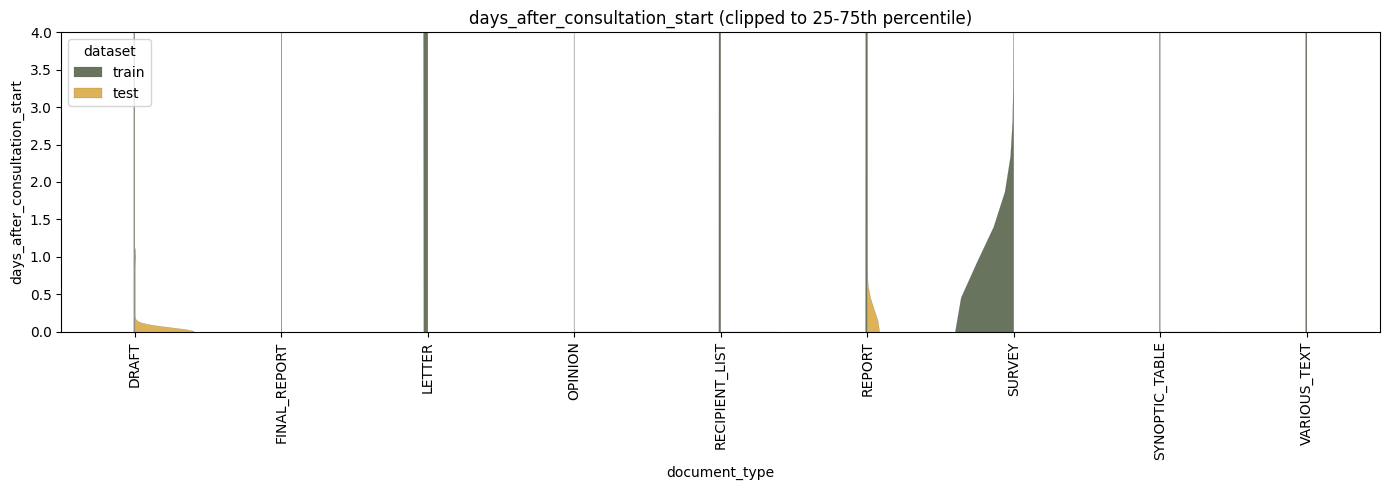

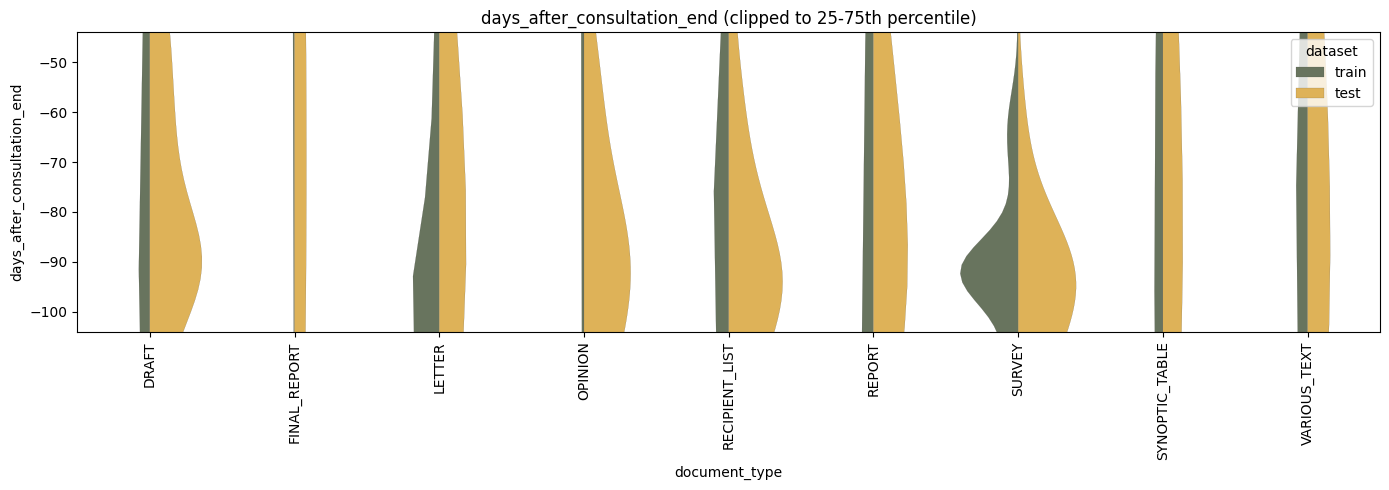

In [25]:
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test_2,
    "days_after_consultation_start",
    clip_y=(25, 75),
)
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test_2,
    "days_after_consultation_end",
    clip_y=(25, 75),
)

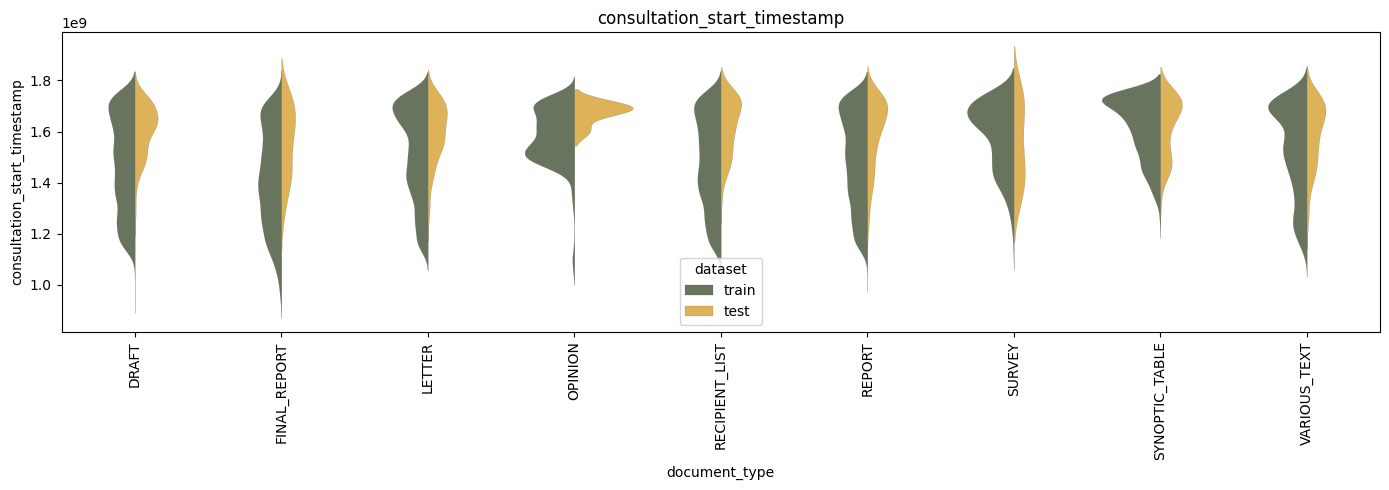

In [26]:
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test_2,
    "consultation_start_timestamp",
    # clip_y=(25, 75),
)

# Classification

In [27]:
mlflow.log_param("extra_feature_columns", sorted(demokratis_ml.models.document_types.model.EXTRA_FEATURE_COLUMNS))
mlflow.log_param(
    "extra_categorical_feature_columns", sorted(demokratis_ml.models.document_types.model.EXTRA_CATEGORICAL_COLUMNS)
)

X_train, y_train = demokratis_ml.models.document_types.model.create_matrices(df_input_train)
X_test_1, y_test_1 = demokratis_ml.models.document_types.model.create_matrices(df_input_test_1)
X_test_2, y_test_2 = demokratis_ml.models.document_types.model.create_matrices(df_input_test_2)

print("train", X_train.shape)
print("test_1", X_test_1.shape)
print("test_2", X_test_2.shape)

train (17981, 3084)
test_1 (0, 0)
test_2 (695, 3084)


## Hyperoptimisation on test_1

In [28]:
def objective_function(params: dict[str, Any]) -> dict[str, Any]:
    logging.info("Training for hyperparameters: %s", params)
    # return {"loss": 1, "status": hyperopt.STATUS_OK}
    classifier = demokratis_ml.models.document_types.model.create_classifier(
        embedding_dimension=embedding_dimension,
        random_state=RANDOM_STATE,
        params=params,
    )
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test_1)
    f1 = sklearn.metrics.f1_score(y_test_1, y_pred, average="weighted", zero_division=np.nan)
    logging.info("F1=%.3f for %s", f1, params)
    return {"loss": -f1, "status": hyperopt.STATUS_OK, "params": params, "f1": f1}


max_evals = 1000

# See https://github.com/hyperopt/hyperopt/issues/253 about the scope.int call
quniform = lambda name, low, high, q: pyll.base.scope.int(hyperopt.hp.quniform(name, low, high, q))  # noqa: E731

search_space = {
    "pca_n_components": quniform("pca_n_components", 50, 400, 10),
    "classifier": hyperopt.hp.choice(
        "classifier",
        [
            # {
            #     "type": "LogisticRegression",
            # },
            # {
            #     "type": "SVC",
            #     # "C": hyperopt.hp.lognormal("svm_C", 0, 1),
            #     "C": hyperopt.hp.loguniform("svm_C", np.log(1e-3), np.log(1e3)),
            #     "gamma": hyperopt.hp.loguniform("svm_gamma", np.log(1e-4), np.log(1e1)),
            #     "kernel": hyperopt.hp.choice(
            #         "svm_kernel",
            #         [
            #             {"type": "poly", "degree": quniform("svm_poly_degree", 2, 5, 1)},
            #             {"type": "rbf"},
            #             {"type": "sigmoid"},
            #         ],
            #     ),
            #     "class_weight": hyperopt.hp.choice("svm_class_weight", ["balanced", None]),
            # },
            {
                "type": "MLP",
                # Choose number of layers (1 to 3)
                "n_layers": quniform("n_layers", 1, 3, 1),
                # Neurons per layer (up to 3 layers, fill with dummy values if not used)
                "layer_1": quniform("layer_1", 16, 256, 16),
                "layer_2": quniform("layer_2", 16, 256, 16),
                "layer_3": quniform("layer_3", 16, 256, 16),
                "activation": hyperopt.hp.choice("activation", ["relu", "tanh", "logistic"]),
                "solver": hyperopt.hp.choice("solver", ["adam", "sgd"]),
                "learning_rate_init": hyperopt.hp.loguniform("learning_rate_init", np.log(1e-4), np.log(1e-1)),
                "alpha": hyperopt.hp.loguniform("alpha", np.log(1e-5), np.log(1e-1)),  # L2 regularization
                "batch_size": quniform("batch_size", 32, 256, 16),
            },
            # {
            #     "type": "MLP",
            #     "hidden_layer_sizes": hyperopt.hp.choice(
            #         "hidden_layer_sizes",
            #         [
            #             (quniform("hidden_layer_size", 64, 512, 32),),
            #             (
            #                 quniform("hidden_layer_size_0", 64, 512, 32),
            #                 quniform("hidden_layer_size_1", 64, 512, 32),
            #             ),
            #         ],
            #     ),
            # },
            # {
            #     "type": "RandomForest",
            #     "n_estimators": quniform("rf_n_estimators", 10, 200, 10),
            #     "criterion": hyperopt.hp.choice("rf_criterion", ["gini", "entropy", "log_loss"]),
            #     "max_depth": hyperopt.hp.choice("rf_max_depth_choice", [None, quniform("rf_max_depth", 5, 50, 1)]),
            #     "min_samples_split": quniform("rf_min_samples_split", 2, 20, 1),
            #     "min_samples_leaf": quniform("rf_min_samples_leaf", 1, 20, 1),
            #     "class_weight": hyperopt.hp.choice("rf_class_weight", ["balanced", None]),
            # },
        ],
    ),
}

if RUN_HYPEROPTIMIZATION:
    assert HYPERPARAMETERS is None, "HYPERPARAMETERS should be pre-defined when running hyperoptimization"
    trials = hyperopt.Trials()
    best_params = hyperopt.fmin(
        objective_function,
        search_space,
        algo=hyperopt.tpe.suggest,
        max_evals=max_evals,
        trials=trials,
    )
    display(best_params)
    assert trials.best_trial
    print(f"F1 {trials.best_trial['result']['f1']:.4f}")
    HYPERPARAMETERS = trials.best_trial["result"]["params"]
else:
    print("Using pre-defined hyperparameters")

Using pre-defined hyperparameters


In [29]:
mlflow.log_param("hyperparameters", HYPERPARAMETERS)

{'classifier': {'type': 'XGBoost'}, 'pca_n_components': 100}

## CV

In [30]:
mlflow.sklearn.autolog()

2025/11/18 15:26:56 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


In [31]:
classifier_cv = demokratis_ml.models.document_types.model.create_classifier(
    embedding_dimension=embedding_dimension,
    params=HYPERPARAMETERS,
    random_state=RANDOM_STATE,
)
classifier_cv

,steps,"[('passthrough', ...), ('columntransformer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('embeddings', ...), ('extra_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [32]:
cv = sklearn.model_selection.StratifiedKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)


def explained_variance_scorer(pipeline: sklearn.pipeline.Pipeline, X: Any, y: Any = None) -> np.float64:
    pca = demokratis_ml.models.document_types.model.get_pca_step(pipeline)
    if pca is None:
        return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


scoring = {
    "precision": "precision_weighted",
    "recall": "recall_weighted",
    "f1": "f1_weighted",
    "pca_explained_variance": explained_variance_scorer,
    "accuracy": "accuracy",
    "top_k_accuracy": "top_k_accuracy",
    # "top_k_accuracy": sklearn.metrics.make_scorer(sklearn.metrics.top_k_accuracy_score, k=3),
}

print("cross_validate...")
cv_scores = sklearn.model_selection.cross_validate(
    classifier_cv, X=X_train, y=y_train, cv=cv, scoring=scoring, verbose=1, n_jobs=-1
)
display(cv_scores)

print("\ncross_val_predict...")
y_cv_predicted = sklearn.model_selection.cross_val_predict(
    classifier_cv, X=X_train, y=y_train, cv=cv, verbose=2, n_jobs=-1
)

cross_validate...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_res

{'fit_time': array([10.22178888, 10.36756992, 10.63366127, 10.48649502, 10.37797785]),
 'score_time': array([0.316401  , 0.3001039 , 0.23413992, 0.25170088, 0.30079293]),
 'test_precision': array([0.95548684, 0.95534267, 0.95502398, 0.95768716, 0.95504934]),
 'test_recall': array([0.95607451, 0.9557842 , 0.9557842 , 0.95828699, 0.9557842 ]),
 'test_f1': array([0.95529823, 0.95503969, 0.95467874, 0.95731414, 0.95506448]),
 'test_pca_explained_variance': array([0.65207559, 0.65216368, 0.65158033, 0.65162843, 0.65205586]),
 'test_accuracy': array([0.95607451, 0.9557842 , 0.9557842 , 0.95828699, 0.9557842 ]),
 'test_top_k_accuracy': array([0.98804559, 0.9852614 , 0.98887653, 0.98637375, 0.98720801])}

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.



cross_val_predict...


/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/vita/.pyenv/versions/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from usi

In [33]:
utils.log_metrics(**{k.replace("test_", "cv_"): np.mean(v) for k, v in cv_scores.items() if k.startswith("test_")})

{'cv_accuracy': 0.9563,
 'cv_f1': 0.9555,
 'cv_pca_explained_variance': 0.6519,
 'cv_precision': 0.9557,
 'cv_recall': 0.9563,
 'cv_top_k_accuracy': 0.9872}


                precision    recall  f1-score   support

         DRAFT       0.94      0.95      0.95      3584
  FINAL_REPORT       0.98      0.97      0.97      1993
        LETTER       0.99      0.99      0.99      3667
       OPINION       0.99      0.96      0.98      1055
RECIPIENT_LIST       0.99      1.00      1.00      2403
        REPORT       0.91      0.96      0.94      3205
        SURVEY       0.96      0.87      0.91       252
SYNOPTIC_TABLE       0.95      0.95      0.95       827
  VARIOUS_TEXT       0.83      0.69      0.75       995

      accuracy                           0.96     17981
     macro avg       0.95      0.93      0.94     17981
  weighted avg       0.96      0.96      0.96     17981



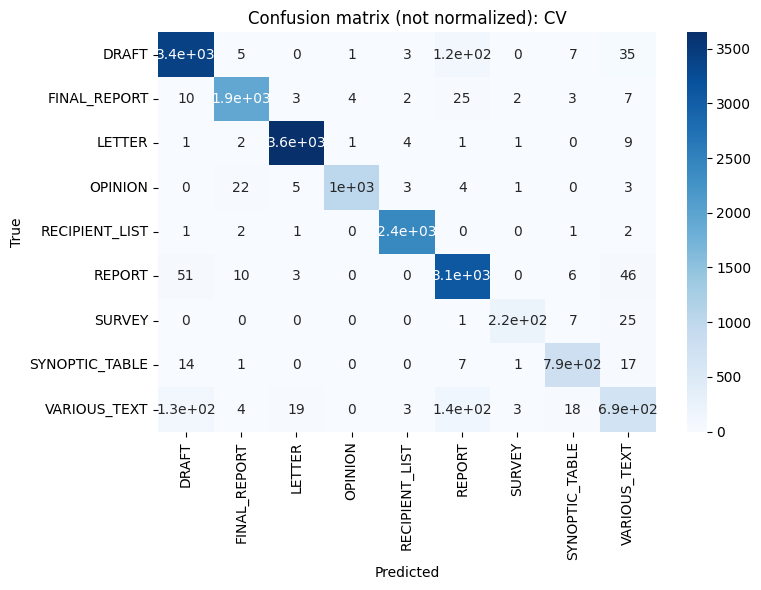

In [34]:
report = sklearn.metrics.classification_report(y_train, y_cv_predicted, zero_division=np.nan)
mlflow.log_text(report, "cv_classification_report.txt")
print(report)
cm = plotting.plot_confusion_matrix_heatmap(y_train, y_cv_predicted, title="CV")
mlflow.log_figure(cm, "cv_confusion_matrix.png")
display(cm)

## Training

In [35]:
classifier_test = demokratis_ml.models.document_types.model.create_classifier(
    embedding_dimension=embedding_dimension,
    params=HYPERPARAMETERS,
    random_state=RANDOM_STATE,
)
classifier_test.fit(X_train, y_train)

2025/11/18 15:27:23 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/11/18 15:27:35 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


,steps,"[('passthrough', ...), ('columntransformer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('embeddings', ...), ('extra_features', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Evaluation on test_2

                precision    recall  f1-score   support

         DRAFT       0.93      0.88      0.90        97
  FINAL_REPORT       0.90      0.73      0.81        26
        LETTER       0.99      1.00      1.00       139
       OPINION       0.80      0.80      0.80         5
RECIPIENT_LIST       1.00      0.98      0.99        61
        REPORT       0.83      0.98      0.90       169
        SURVEY       1.00      0.87      0.93        15
SYNOPTIC_TABLE       0.94      0.98      0.96        82
  VARIOUS_TEXT       0.91      0.71      0.80       101

      accuracy                           0.92       695
     macro avg       0.92      0.88      0.90       695
  weighted avg       0.92      0.92      0.92       695



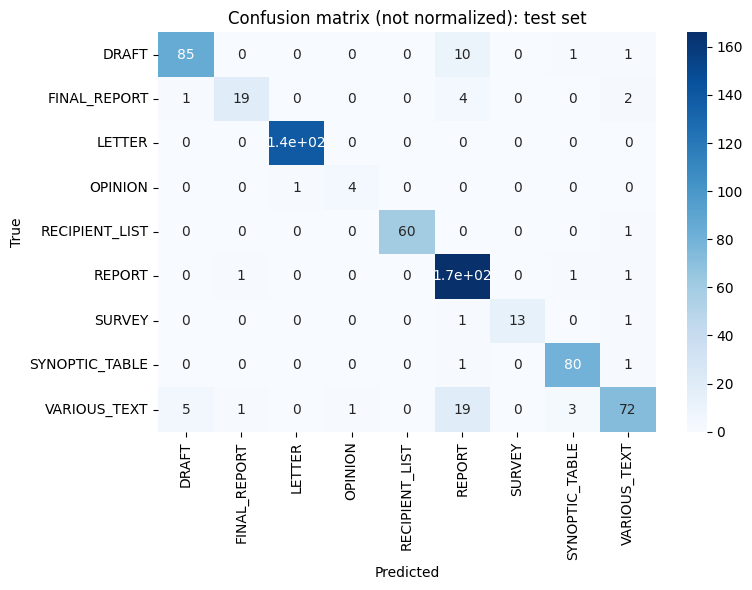

{'test_accuracy': 0.918,
 'test_f1': 0.9161,
 'test_precision': 0.9222,
 'test_recall': 0.918}


In [36]:
y_test_2_predicted = classifier_test.predict(X_test_2)

# Classification report
report = sklearn.metrics.classification_report(
    y_test_2,
    y_test_2_predicted,
    zero_division=np.nan,
)
mlflow.log_text(report, "test_classification_report.txt")
print(report)

# Confusion matrix
cm = plotting.plot_confusion_matrix_heatmap(y_test_2, y_test_2_predicted, title="test set")
mlflow.log_figure(cm, "test_confusion_matrix.png")
display(cm)

# Metrics
test_metrics = sklearn.metrics.precision_recall_fscore_support(
    y_test_2,
    y_test_2_predicted,
    average="weighted",
    zero_division=np.nan,
)
utils.log_metrics(
    test_precision=test_metrics[0],
    test_recall=test_metrics[1],
    test_f1=test_metrics[2],
    test_accuracy=sklearn.metrics.accuracy_score(y_test_2, y_test_2_predicted),
    # test_top_k_accuracy=sklearn.metrics.top_k_accuracy_score(y_test_2, classifier_test_2.predict_proba(X_test_2)),
)

### Feature importance (random forest only)

In [37]:
# forest = classifier_test.named_steps["randomforestclassifier"]
# pca = demokratis_ml.models.document_types.model.get_pca_step(classifier_test)
# assert pca is not None

# forest_importances = pd.Series(
#     forest.feature_importances_,
#     index=(
#         [f"embedding_{i:02d}" for i in range(pca.n_components)]
#         + list(demokratis_ml.models.document_types.model.EXTRA_FEATURE_COLUMNS)
#         + list(demokratis_ml.models.document_types.model.EXTRA_CATEGORICAL_COLUMNS)
#     ),
# )
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# fig, ax = plt.subplots(figsize=(12, 2.5 * np.log(len(forest_importances))))
# forest_importances.plot.barh(xerr=std, ax=ax)
# ax.invert_yaxis()  # start with embeddings at the top
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

# mlflow.log_figure(fig, "feature_importance_mdi.png")

### Results per canton

In [38]:
df_eval = df_input_test_2.copy()
df_eval["document_type_predicted"] = y_test_2_predicted

for canton_code, df_canton in df_eval.groupby("political_body", observed=False):
    # Skip the "ch" political_body, which is the federal level and not a canton
    if canton_code == "ch":
        continue
    print(f"\n{'-' * 60}\n{canton_code}\n{'-' * 60}")
    if df_canton.empty:
        print("No data")
    else:
        report = sklearn.metrics.classification_report(
            df_canton["document_type"], df_canton["document_type_predicted"], zero_division=np.nan
        )
        print(report)


------------------------------------------------------------
bs
------------------------------------------------------------
                precision    recall  f1-score   support

         DRAFT       1.00      1.00      1.00         7
        LETTER       1.00      1.00      1.00         8
        REPORT       1.00      0.88      0.93         8
SYNOPTIC_TABLE       1.00      1.00      1.00         3
  VARIOUS_TEXT       0.80      1.00      0.89         4

      accuracy                           0.97        30
     macro avg       0.96      0.97      0.96        30
  weighted avg       0.97      0.97      0.97        30


------------------------------------------------------------
sh
------------------------------------------------------------
                precision    recall  f1-score   support

         DRAFT       1.00      1.00      1.00         1
  FINAL_REPORT       1.00      1.00      1.00         2
        LETTER       1.00      1.00      1.00         3
RECIPIENT_LIST  

## Comparison to the rule-based model

In [39]:
# We must erase the true labels first because the rule-based model doesn't overwrite existing labels.
_df = df_input_test_2.copy()
_df.loc[:, "document_type"] = None
# Explicit class-merging step is needed because the rule-based model may output any class.
y_test_predicted_rules = demokratis_ml.models.document_types.preprocessing.merge_classes(
    document_title_rule_model.predict(_df),
    demokratis_ml.models.document_types.preprocessing.MERGE_CLASSES,
)

INFO document_title_rule_model: 0.00% of documents already have labels
INFO document_title_rule_model: Labelled 0.58% by rule: canton=<any>, title^=adressliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 2.73% by rule: canton=<any>, title^=adressatenliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.14% by rule: canton=<any>, title^=adressatenverzeichnis => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 1.01% by rule: canton=<any>, title^=vernehmlassungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=vernehmlassungsadressen => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=verzeichnis der anhörungsadressaten => type=RECIPIENT_LIST
WARNING document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=liste der konsultationsadressatinnen und konsultationsadressaten => type=RECIPIENT_LIST
INFO document_title

                precision    recall  f1-score   support

         DRAFT       0.65      0.98      0.78        61
  FINAL_REPORT       0.71      0.67      0.69        15
        LETTER       0.98      1.00      0.99       133
RECIPIENT_LIST       1.00      0.98      0.99        53
        REPORT       0.92      0.83      0.87       136
        SURVEY       1.00      1.00      1.00        12
SYNOPTIC_TABLE       1.00      0.86      0.93        66
  VARIOUS_TEXT       0.94      0.72      0.82        47

      accuracy                           0.90       523
     macro avg       0.90      0.88      0.88       523
  weighted avg       0.92      0.90      0.90       523



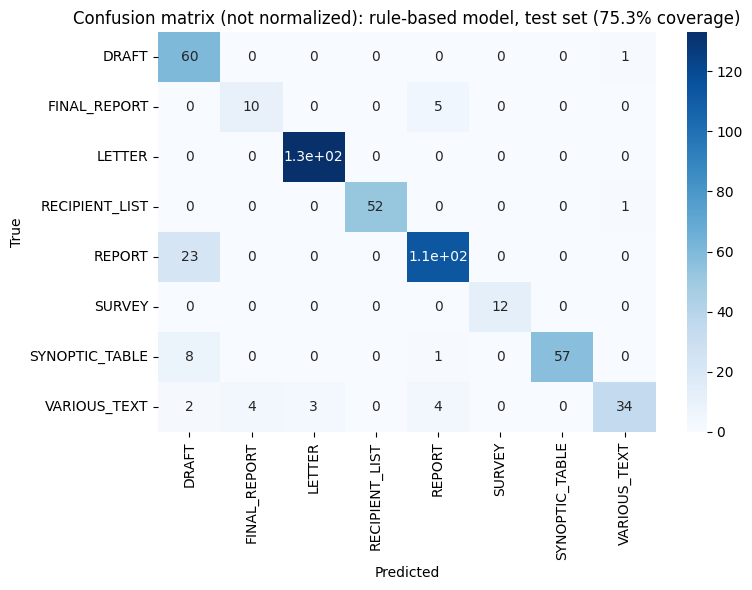

In [40]:
_y_true = y_test_2[y_test_predicted_rules.notna()]
_y_predicted = y_test_predicted_rules[y_test_predicted_rules.notna()]

coverage = np.mean(y_test_predicted_rules.notna())
print(sklearn.metrics.classification_report(_y_true, _y_predicted, zero_division=np.nan))
plotting.plot_confusion_matrix_heatmap(
    _y_true,
    _y_predicted,
    title=f"rule-based model, test set ({100 * coverage:.1f}% coverage)",
    # normalize="true",
)

## Display all test samples & predictions

In [41]:
# Uncomment to display a comparison of rule-based and ML-based predictions for every test document.

# df_display = df_input_test_2.copy()
# df_display["prediction_rule"] = y_test_predicted_rules
# df_display["prediction_ml"] = y_test_2_predicted

# df_display[
#     [
#         "document_uuid",
#         "political_body",
#         "consultation_url",
#         "document_source_url",
#         "document_title",
#         "document_type",
#         "prediction_rule",
#         "prediction_ml",
#     ]
# ].style.format(
#     {
#         "consultation_url": lambda x: f'<a href="{x}">vnl</a>',
#         "document_source_url": lambda x: f'<a href="{x}">doc</a>',
#     }
# ).apply(
#     lambda row: [
#         f"color: {'green' if row[col] == row['document_type'] else 'red'}"
#         if col in {"prediction_rule", "prediction_ml"}
#         else ""
#         for col in row.index
#     ],
#     axis=1,
# ).set_table_styles([{"selector": "th,td", "props": [("text-align", "left")]}])

***

# End run

In [42]:
# mlflow.sklearn.log_model(
#     classifier_test,
#     artifact_path="model",
#     registered_model_name="document_type_classifier",
# )

In [43]:
mlflow.end_run()

🏃 View run tasteful-fowl-449 at: https://mlflow.ml1.demokratis.ch/#/experiments/4/runs/e0e720bff3664f0fb4146bfeacc32cb5
🧪 View experiment at: https://mlflow.ml1.demokratis.ch/#/experiments/4


***

# Cleanlab

In [44]:
RUN_CLEANLAB = False

In [45]:
import cleanlab

from research.lib import cleanlab_analysis

if RUN_CLEANLAB:
    df_cleanlab = pd.concat([df_input_train, df_input_test_1, df_input_test_2], ignore_index=True)
    X_cleanlab, y_cleanlab = demokratis_ml.models.document_types.model.create_matrices(df_cleanlab)
    print(X_cleanlab.shape)
    classifier_cleanlab = demokratis_ml.models.document_types.model.create_classifier(
        embedding_dimension=embedding_dimension,
        params=HYPERPARAMETERS,
        random_state=RANDOM_STATE,
    )
    pred_probs = sklearn.model_selection.cross_val_predict(
        estimator=classifier_cleanlab,
        X=X_cleanlab,
        y=y_cleanlab,
        cv=CV_FOLDS,
        method="predict_proba",
        n_jobs=-1,
        verbose=2,
    )
    print(pred_probs.shape)
    assert pred_probs.shape[0] == len(df_cleanlab)

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO datasets: Duckdb version 1.3.2 available.


In [46]:
if RUN_CLEANLAB:
    lab = cleanlab.Datalab(data=df_cleanlab, label_name="document_type")
    lab.find_issues(pred_probs=pred_probs, features=X_cleanlab)
    lab.report()

In [47]:
if RUN_CLEANLAB:
    df_output = df_cleanlab.copy()
    df_output["year"] = df_output["consultation_start_date"].dt.year
    df_output["edit_link"] = df_output.apply(
        lambda d: f"https://www.demokratis.ch/de/consultation/{d['consultation_identifier']}/admin/document/{d['document_uuid']}/edit",
        axis=1,
    )
    df_output = df_output[
        [
            "edit_link",
            "consultation_identifier",
            "document_uuid",
            "political_body",
            "year",
            "consultation_url",
            "document_source_url",
            "document_title",
            "document_type",
            # Features:
            "count_pages",
            "count_pages_containing_tables",
            "average_page_aspect_ratio",
            "fraction_pages_containing_tables",
            "contains_synopse_keyword",
            "contains_salutation",
        ]
    ]

    cleanlab_analysis.cleanlab_issues_to_excel(
        lab,
        pred_probs=pred_probs,
        dataset=df_output,
        output_path=f"cleanlab_issues_{DATA_VERSION}.xlsx",
        linkify_columns={
            "edit_link",
            "consultation_url",
            # "document_source_url",  # Odd characters in some URLs cause Excel errors
        },
        issue_types=(
            "label",
            # "near_duplicate",
            # "outlier",
            # "underperforming_group",
            # "non_iid",
        ),
    )